<a href="https://colab.research.google.com/github/yun-aha/GSTEC/blob/main/210805.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 웹 어플리케이션

로그인이 되어 있찌 않아도 article/detail페이지에 들어갈 수 있기 때문에 decorator을 다시 사용하여 막아준다.  
create에서 바로 detail창으로 들어가도록 설정  
decorator를 사용

In [ ]:
# gsweb\articleapp\views.py
@method_decorator(login_required, 'get')
@method_decorator(login_required, 'post')
class ArticleCreateView(CreateView):
    model = Article
    form_class = ArticleCreationForm
    template_name = 'articleapp/create.html'
    def form_valid(self, form):
        form.instance.writer = self.request.user
        return super().form_valid(form)
    def get_success_url(self):
        return reverse('articleapp:detail',kwargs={'pk':self.object.pk})

# gsweb\articleapp\decorators.py
from django.http import HttpResponseForbidden

from articleapp.models import Article


def article_ownership_required(func):
    def decorated(request, *args, **kwargs):
        target_article = Article.objects.get(pk=kwargs['pk'])
        if target_article.writer == request.user:
            return func(request, *args, **kwargs)
        else:
            return HttpResponseForbidden()
    return decorated


# gsweb\articleapp\views.py
@method_decorator(article_ownership_required,'get')
@method_decorator(article_ownership_required,'post')
class ArticleUpdateView(UpdateView):
    model = Article
    form_class = ArticleCreationForm
    context_object_name = 'target_article'
    template_name = 'articleapp/update.html'

    def get_success_url(self):
        return reverse('articleapp:detail',kwargs={'pk':self.object.pk})

@method_decorator(article_ownership_required,'get')
@method_decorator(article_ownership_required,'post')
class ArticleDeleteView(DeleteView):
    model = Article
    context_object_name = 'target_article'
    success_url = reverse_lazy('articleapp:list')
    template_name = 'articleapp/delete.html'


In [ ]:
# gsweb\articleapp\templates\articleapp\detail.html
{% extends 'base.html' %}

{% block content %}

    <div class="container text-center">
        <div class="my-5">

            {#      제목, 글쓴이, 작성일    #}
            <h1 class="NNS_B">{{ target_article.title }}</h1>
            <h3>{{ target_article.writer.profile.nickname }}</h3>
            <p>{{ target_article.created_at }}</p>
        </div>
        <hr>
        <div class="my-5">
            {#      게시글 대표이미지, 글 내용     #}
            <img src="{{ target_article.image.url }}"
                 class="article_image"
                 alt="">
            <div class="article_content">
                {{ target_article.content }}
            </div>
            {% if target_article.writer == user %}
            <div>
                <a href="{% url 'articleapp:update' pk=target_article.pk %}"
                class="btn btn-success rounded-pill px-5">
                    Update
                </a>
                <a href="{% url 'articleapp:delete' pk=target_article.pk %}"
                class="btn btn-danger rounded-pill px-5">
                    Delete
                </a>
            </div>
            {% endif %}
        </div>
    </div>




{% endblock %}

In [ ]:
# gsweb\static\base.css

.article_image{
    border-radius: 2rem;
    width: 70%;
    box-shadow: 0 0 .5rem grey;
}
.article_content{
    font-size: 1.1rem;
    text-align: left;
    margin: 2rem;
}

### page ination  
generate page of objects  
page 짜르기..  


In [ ]:
# gsweb\articleapp\views.py
class ArticleListView(ListView):
    model = Article
    context_object_name = 'article_list'
    template_name = 'articleapp/list.html'
    paginate_by = 20

# gsweb\articleapp\urls.py
urlpatterns = [
    path('list/', ArticleListView.as_view(), name='list'),
    path('create/', ArticleCreateView.as_view(), name='create'),
    path('detail/<int:pk>', ArticleDetailView.as_view(), name='detail'),
    path('update/<int:pk>', ArticleUpdateView.as_view(), name='update'),
    path('delete/<int:pk>', ArticleDeleteView.as_view(), name='delete'),
]


In [ ]:
# gsweb\articleapp\templates\articleapp\list.html
{% extends 'base.html' %}
{% load static %}
{% block content %}

    <style>
        .container div {
          width: 280px;
          background-color: lightseagreen;
          display: flex;
          justify-content: center;
          align-items: center;
          border-radius: 1rem;
            flex-direction: column;
        }
    .container img{
        width: 100%;
        border-radius: 1rem;
    }
    </style>


    <!DOCTYPE html>
    <div class="container my-4">

        {% for article in article_list %}
            <div>
                <a href="{% url 'articleapp:detail' pk=article.pk %}">
                    <img src="{{ article.image.url }}"
                         alt="">
                </a>
            <span>{{ article.title }}</span>
            </div>
        {% endfor %}

    </div>

    <script src="{% static 'js/magicgrid.js' %}"></script>
    <div class="text-center my-5">
        <a href="{% url 'articleapp:create' %}"
        class="btn btn-dark rounded-pill material-icons">
            brush
        </a>
        <a href="{% url 'articleapp:create' %}"
        class="btn btn-outline-dark rounded-pill px-5">
            Create Article
        </a>
    </div>
{% endblock %}

# 2. 알고리즘

# 3. 딥러닝

# 4. 머신러닝

In [ ]:
!pip install mglearn

     |████████████████████████████████| 540 kB 5.2 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=4fefc680658c18fd2f97835f73bbf123096df72cef56b8d1c3c0d3f8587b6f8a
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


#### Decision Tree 실습 04

타이타닉 데이터 사용

In [ ]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 구글 드라이브 파일 확인
!ls '/gdrive/My Drive/temp/'

# 반복되는 드라이브 경로 변수화
drive_path = '/gdrive/My Drive/temp/'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# df = pd.read_excel(drive_path + 'titanic.xls')
df = pd.read_excel('/content/titanic.xls')

##### 데이터 분석 (시각화, EDA - 탐색적 데이터분석)

- 데이터를 세부적으로 살펴보는 것 <br> 
  (결측치, 이상치, 데이터분포, 라벨의 분포, 범주형 데이터의 종류 등 확인)
- 데이터를 시각화
- 데이터를 어떻게 수정할 것인지 결정

In [ ]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


- pclass : 객실 등급
- survived : 생존 유무
- sex : 성별
- age : 나이
- sibsp : 형제 혹은 부부의 수
- parch : 부모, 혹은 자녀의 수
- fare : 지불한 운임
- boat : 탈출한 보트가 있다면 boat 번호
- embarked : 탑승장소 S=Southhampton, C=Cherbourg, Q=Queenstown

In [ ]:
# 이상치 확인
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


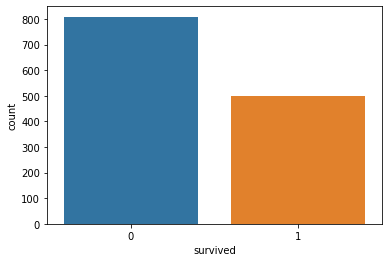

In [ ]:
# 생존자 수 확인
import seaborn as sns

# countplot: 범주형 변수의 빈도수를 시각화
sns.countplot('survived', data=df)

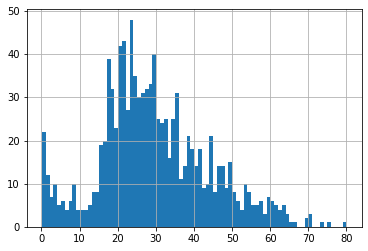

In [ ]:
# 나이순으로 숫자 보기
df['age'].hist(bins=80)

In [ ]:
# 선실 등급별 상황
df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


**heatmap**

- Target Feature와 나머지 독립변수들의 상관계수를 직관적으로 확인
- 데이터.corr() : heatmap에 사용할 데이터의 상관계수

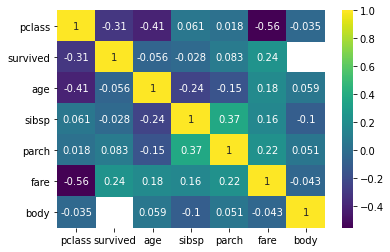

In [ ]:
# 특성의 상관관계 분석
sns.heatmap(df.corr(), cmap=plt.cm.viridis, annot=True)

- 생존률과의 관계?


In [ ]:
# 객실 등급(pclass)별, 연령대별, 성별 비교

# seaborn은 barplot() 함수를 사용할 때 
# 각 막대에 기본적으로 오차막대(error bar)가 함께 나타나도록 되어 있다.
# 오차막대를 그리는 범위는 기본적으로 
# “이 데이터를 기반으로 유사한 상황의 95%가 이 범위 내에서 결과를 얻을 것”을 의미한다.
x = df['age']
bins = [0, 10, 20, 50, 100]
labels = ['baby', 'teenage', 'adult', 'old']
df['age_cut'] = pd.cut(x=x, bins=bins, labels=labels)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


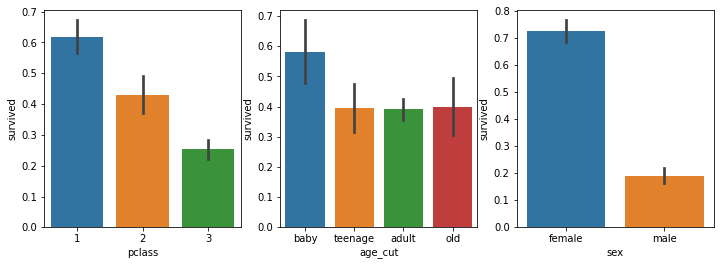

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4) )
sns.barplot('pclass', 'survived', data=df, ax=axes[0])
sns.barplot('age_cut', 'survived', data=df, ax=axes[1])
sns.barplot('sex', 'survived', data=df, ax=axes[2])

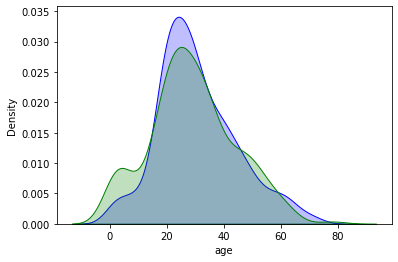

In [ ]:
# 연령대별 생존여부 분포 비교
# 커널밀도추정 KDE ; 데이터의 분포를 확인
# df['age'][ df['survived'] == 0 ][ df['age'].notnull() ]
survived_0 = df['age'][ (df['survived'] == 0) & (df['age'].notnull()) ]
survived_1 = df['age'][ (df['survived'] == 1) & (df['age'].notnull()) ]
sns.kdeplot(survived_0, shade=True, color='b')
sns.kdeplot(survived_1, shade=True, color='g')

- 성별 생존자수 비교 결과?


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


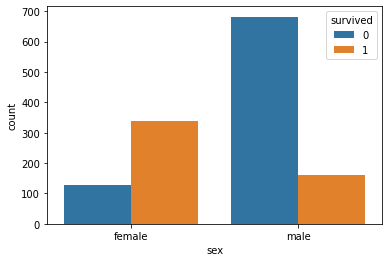

In [ ]:
# 성별 생존자수 비교
# sns.countplot('sex', data=df)
sns.countplot('sex',hue='survived',data=df)

- 구조 보트에 탑승하고도 사망한 비율 ??%


1    477
0      9
Name: survived, dtype: int64

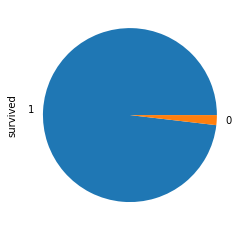

In [ ]:
# 구조 보트에 탑승하고도 사망한 비율
boat_df = df[ df['boat'].notnull() ]
# sns.countplot('survived', data=boat_df)
boat_df['survived'].value_counts().plot.pie()
boat_df['survived'].value_counts()